### 必要なライブラリをインポート

In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
# numpyは数値計算用、PILは画像処理用、matplotlibは画像の表示用

### 32x32ピクセルの黒い画像を作成し，中央に白い6を描画

In [2]:
pixel = 32
black_image = Image.new('1', (pixel, pixel), 0)  # '1'モードで黒い画像を作成 # '1'モードとは白黒画像のこと

draw = ImageDraw.Draw(black_image) # 画像に描画するためのオブジェクトを作成

# フォントの設定 # フォントサイズを設定し，Arialフォントを読み込む．Arialフォントが利用できない場合はデフォルトフォントを使用．
font_size = 30
try:
    font = ImageFont.truetype("arial", font_size)
except IOError:
    font = ImageFont.load_default()

# テキストを中央に配置するための位置を計算
text = "7"
bbox = draw.textbbox((0, 0), text, font=font)
text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
position = ((pixel - text_width) // 2, (20 - text_height) // 2)

# テキストを描画（白色で描画）
draw.text(position, text, font=font, fill=1)  # fill=1は白を表す

### 計算

In [3]:
# 黒い画像をNumPy配列に変換
black_image_array = np.array(black_image)

# 積の平均を計算するための累積配列を初期化
sum_Scattered_light_intensity = np.zeros((32, 32), dtype=np.float64)
sum_Lighting_pattern = np.zeros((32, 32), dtype=np.float64)
sum_BI = np.zeros((32, 32), dtype=np.float64)

# Nパターンのランダム画像に対して計算
num_samples = 1000
for _ in range(num_samples):
    Lighting_pattern = np.random.randint(2, size=(32, 32), dtype=np.uint8)  # 照射パターン # 0と1のランダムな配列
    Scattered_light_intensity_array = black_image_array * Lighting_pattern #散乱光強度(行列) # 各ピクセルの積を計算
    Scattered_light_intensity = np.sum(Scattered_light_intensity_array) #散乱光強度(スカラー) # 散乱光強度(行列)の各要素の和
    BI = Scattered_light_intensity * Lighting_pattern # 散乱光強度と照射パターンの積
    sum_Scattered_light_intensity += Scattered_light_intensity  # 積を累積
    sum_Lighting_pattern += Lighting_pattern # 照射パターンを累積
    sum_BI += BI # BIを累計

# 平均を計算
mean_Scattered_light_intensity = sum_Scattered_light_intensity / num_samples
mean_Lighting_pattern = sum_Lighting_pattern / num_samples
mean_BI = sum_BI / num_samples

# 相関関数Gを計算
G_correlation_function = mean_BI - (mean_Scattered_light_intensity * mean_Lighting_pattern)

### 結果を画像に変換

In [4]:
# 相関関数Gを画像に変換（0-255の範囲にスケール）
G_correlation_image = Image.fromarray(
    ((G_correlation_function - np.min(G_correlation_function)) / 
     (np.max(G_correlation_function) - np.min(G_correlation_function)) * 255).astype(np.uint8)
)

### 画像を表示

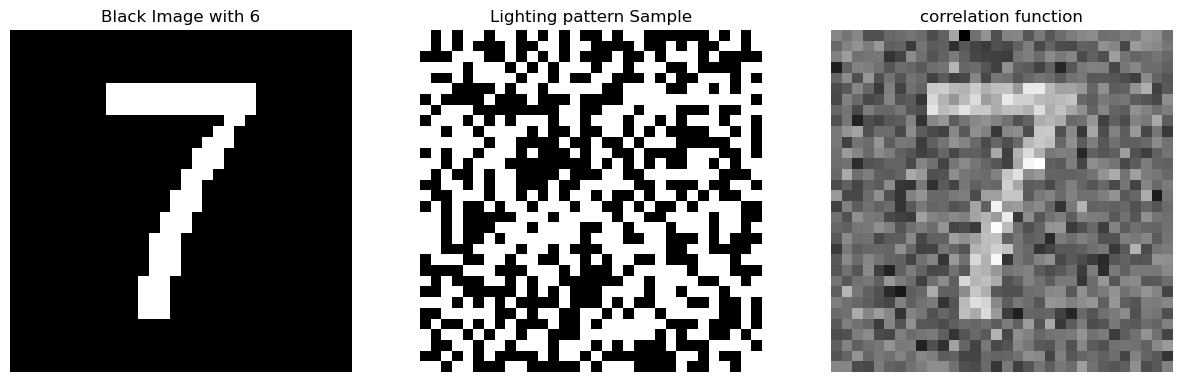

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(black_image, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Black Image with 6')
axes[0].axis('off')

# 一つのサンプルとして最初のランダム画像を表示
random_image_sample = Image.fromarray(Lighting_pattern * 255)
axes[1].imshow(random_image_sample, cmap='gray', vmin=0, vmax=255)
axes[1].set_title('Lighting pattern Sample')
axes[1].axis('off')

axes[2].imshow(G_correlation_image, cmap='gray', vmin=0, vmax=255)
axes[2].set_title('correlation function')
axes[2].axis('off')

plt.show()

### CNRを計算

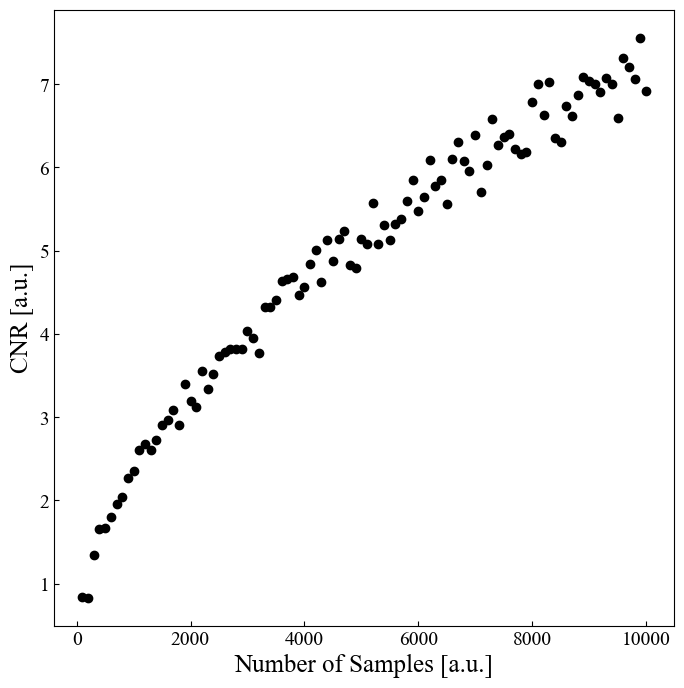

In [8]:
# 各num_samples_CNRごとのCNR値を保存するリスト
CNR_values = []  
sample_points = []

max_samples = 10000  # 最大サンプル数を5000に設定

# num_samples_CNRを100おきに変化させながらループ
for num_samples_CNR in range(100, max_samples + 1, 100):
    sum_Scattered_light_intensity = np.zeros((32, 32), dtype=np.float64)
    sum_Lighting_pattern = np.zeros((32, 32), dtype=np.float64)
    sum_BI = np.zeros((32, 32), dtype=np.float64)

    for _ in range(num_samples_CNR):
        Lighting_pattern = np.random.randint(2, size=(32, 32), dtype=np.uint8)  # 照射パターン # 0と1のランダムな配列
        Scattered_light_intensity_array = black_image_array * Lighting_pattern #散乱光強度(行列) # 各ピクセルの積を計算
        Scattered_light_intensity = np.sum(Scattered_light_intensity_array) #散乱光強度(スカラー) # 散乱光強度(行列)の各要素の和
        BI = Scattered_light_intensity * Lighting_pattern # 散乱光強度と照射パターンの積
        sum_Scattered_light_intensity += Scattered_light_intensity # 積を累積
        sum_Lighting_pattern += Lighting_pattern  # 照射パターンを累積
        sum_BI += BI  # BIを累計

    # 平均を計算
    mean_Scattered_light_intensity = sum_Scattered_light_intensity / num_samples_CNR
    mean_Lighting_pattern = sum_Lighting_pattern / num_samples_CNR
    mean_BI = sum_BI / num_samples_CNR

    # 相関関数Gを計算
    G_correlation_function = mean_BI - (mean_Scattered_light_intensity * mean_Lighting_pattern)

    # 白い部分のマスクを作成（black_image_arrayが1の部分が白）
    white_mask = black_image_array == 1

    # G_correlation_function の白い部分の値を抽出
    white_values = G_correlation_function[white_mask]

    # 白い部分の平均と標準偏差を計算
    s = np.mean(white_values)
    sigma_s = np.std(white_values)

    # 黒い部分のマスクを作成（black_image_arrayが0の部分が黒）
    black_mask = black_image_array == 0

    # G_correlation_function の黒い部分の値を抽出
    black_values = G_correlation_function[black_mask]

    # 黒い部分の平均と標準偏差を計算
    b = np.mean(black_values)
    sigma_b = np.std(black_values)

    # CNRを計算
    CNR = (s - b) / np.sqrt(sigma_s ** 2 + sigma_b ** 2)
    CNR_values.append(CNR)
    sample_points.append(num_samples_CNR)

# CNRの散布図を描画
plt.figure(figsize=(8, 8))
plt.scatter(sample_points, CNR_values, c='black')  # プロットを白黒に設定
plt.xlabel('Number of Samples [a.u.]', fontname='Times New Roman', fontsize=18)  # フォントと文字サイズを設定
plt.ylabel('CNR [a.u.]', fontname='Times New Roman', fontsize=18)  # フォントと文字サイズを設定

# グリッド線を削除
plt.grid(False)

# 内向き目盛
plt.tick_params(axis='both', direction='in')

# フォント設定を適用
plt.xticks(fontname='Times New Roman', fontsize=14)
plt.yticks(fontname='Times New Roman', fontsize=14)

# 画像をファイルに保存
plt.savefig('CNR_vs_num_samples.png')

# グラフを表示
plt.show()